# [COM6513] Assignment 1: Sentiment Analysis with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test a **text classification** system for **sentiment analysis**, in particular to predict the sentiment of movie reviews, i.e. positive or negative (binary classification).



For that purpose, you will implement:


- Text processing methods for extracting Bag-Of-Word features, using 
    - n-grams (BOW), i.e. unigrams, bigrams and trigrams to obtain vector representations of documents where n=1,2,3 respectively. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). 
    - character n-grams (BOCN). A character n-gram is a contiguous sequence of characters given a word, e.g. for n=2, 'coffee' is split into {'co', 'of', 'ff', 'fe', 'ee'}. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). **Tip: Note the large vocabulary size!** 
    - a combination of the two vector spaces (n-grams and character n-grams) choosing your best performing wighting respectively (i.e. raw or tfidf). (**1 mark**) **Tip: you should merge the two representations**



- Binary Logistic Regression (LR) classifiers that will be able to accurately classify movie reviews trained with: 
    - (1) BOW-count (raw frequencies) 
    - (2) BOW-tfidf (tf.idf weighted)
    - (3) BOCN-count
    - (4) BOCN-tfidf
    - (5) BOW+BOCN (best performing weighting; raw or tfidf)



- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function (**1 mark**)
    - Use L2 regularisation (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous development loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)



- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength) for each LR model? You should use a table showing model performance using different set of hyperparameter values. (**2 marks). **Tip: Instead of using all possible combinations, you could perform a random sampling of combinations.**


- After training each LR model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot. Does your model underfit, overfit or is it about right? Explain why. (**1 mark**). 


- Identify and show the most important features (model interpretability) for each class (i.e. top-10 most positive and top-10 negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!). If you were to apply the classifier into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 


- Provide efficient solutions by using Numpy arrays when possible (you can find tips in Lab 1 sheet). Executing the whole notebook with your code should not take more than 5 minutes on a any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs (**2 marks**). 






### Data 

The data you will use are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.




### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex` or you can print it as PDF using your browser).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 14 Mar 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
tune_params = input("tune hyperparameters and show model performance? [Y/N]")

tune hyperparameters and show model performance? [Y/N]Y


In [2]:
while (tune_params != 'Y') & (tune_params != 'N'):
    tune_params = input("tune hyperparameters and show model performance? [Y/N]")

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from prettytable import PrettyTable

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [4]:
training_data = pd.read_csv("data_sentiment/train.csv")
development_data = pd.read_csv("data_sentiment/dev.csv")
test_data = pd.read_csv("data_sentiment/test.csv")

If you use Pandas you can see a sample of the data.

In [5]:
# training_data.sample(5)

The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [6]:
train_content = training_data.iloc[:,0].to_list()
development_content = development_data.iloc[:,0].to_list()
test_content = test_data.iloc[:,0].to_list()
train_label = training_data.iloc[:,1].to_numpy()
development_label = development_data.iloc[:,1].to_numpy()
test_label = test_data.iloc[:,1].to_numpy()

# Vector Representations of Text 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams (or character ngrams from the unigrams)
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (or character n-grams). You can keep top N if you encounter memory issues.


In [7]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']
stop_words = ['a', 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after','afterwards', 'again', 'against', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', 'came', 'can', 'cannot', 'cant', 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co', 'com', 'come', 'comes', 'concerning', 'consequently', 'consider', 'considering', 'contain', 'containing', 'contains', 'corresponding', 'could', 'course', 'currently', 'd','definitely', 'described', 'despite', 'did', 'different', 'do', 'does', 'doing', 'done', 'down', 'downwards', 'during', 'e', 'each', 'edu', 'eg', 'eight', 'either', 'else', 'elsewhere', 'enough', 'entirely', 'especially', 'et', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'f', 'far', 'few', 'fifth', 'first', 'five', 'followed', 'following', 'follows', 'for', 'former', 'formerly', 'forth', 'four', 'from', 'further', 'furthermore', 'g', 'get', 'gets', 'getting', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'got', 'gotten', 'greetings', 'h', 'had', 'happens', 'hardly', 'has', 'have', 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'hi', 'him', 'himself', 'his', 'hither', 'hopefully', 'how', 'howbeit', 'however', 'i', 'ie', 'if', 'ignored', 'immediate', 'in', 'inasmuch', 'inc', 'indeed', 'indicate', 'indicated', 'indicates', 'inner', 'insofar', 'instead', 'into', 'inward', 'is', 'it', 'its', 'itself', 'j', 'just', 'k', 'keep', 'keeps', 'kept', 'know', 'knows', 'known', 'l', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 'less', 'lest', 'let', 'like', 'liked', 'likely', 'little', 'look', 'looking', 'looks', 'ltd', 'm', 'mainly', 'many', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'merely','might', 'more', 'moreover', 'most', 'mostly', 'much', 'must', 'my', 'myself', 'n', 'name', 'namely', 'nd','near', 'nearly', 'necessary', 'need', 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nine', 'no', 'nobody', 'non', 'none', 'noone', 'nor', 'normally', 'not', 'note', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay','old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'p', 'particular', 'particularly', 'per', 'perhaps', 'placed', 'please', 'plus', 'possible', 'presumably', 'probably', 'provides', 'q', 'que', 'quite', 'qv', 'r', 'rather', 'rd', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'relatively', 'respectively', 'right', 's', 'said', 'same', 'saw', 'say', 'saying', 'says', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'she', 'should', 'since', 'six', 'so', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'sorry', 'specified', 'specify', 'specifying', 'still', 'sub', 'such', 'sup', 'sure', 't', 'take', 'taken', 'tell', 'tends', 'th', 'than', 'thank', 'thanks', 'thanx', 'that', 'thats', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'theres', 'thereupon', 'these', 'they', 'think', 'third', 'this', 'thorough', 'thoroughly', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'twice', 'two', 'u', 'un', 'under', 'unfortunately', 'unless', 'unlikely', 'until', 'unto', 'up', 'upon', 'us', 'use', 'used', 'useful', 'uses', 'using', 'usually', 'uucp', 'v', 'value', 'various', 've', 'very', 'via', 'viz', 'vs', 'w', 'want', 'want', 'was', 'way', 'we', 'welcome', 'well', 'went', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon','wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'willing', 'wish', 'with', 'within', 'without', 'wonder', 'would', 'would', 'x', 'y', 'yes', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', 'z', 'zero']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `char_ngrams`: boolean. If true the function extracts character n-grams

and returns:

- `x': a list of all extracted features.

See the examples below to see how this function should work.

In [8]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'[A-Za-z]+', 
                   stop_words=[], vocab=set(), char_ngrams=False):
    x = []
    x_raw = re.findall(token_pattern, x_raw)
    if char_ngrams==True:
        x_raw = ''.join(x_raw)
        for i in range(ngram_range[1]-ngram_range[0]+1):
            for j in range(len(x_raw)-ngram_range[0]-i+1):
                x.append([x_raw[j:j+ngram_range[0]+i]])
        return x
    
    words = [word for word in x_raw if word not in stop_words]
    for i in range(ngram_range[1]-ngram_range[0]+1):
        for j in range(len(words)-ngram_range[0]-i+1):
            x.append(words[j:j+ngram_range[0]+i])
    return x

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

For extracting character n-grams the function should work as follows:

In [9]:
extract_ngrams("movie", 
               ngram_range=(2,4), 
               stop_words=[],
               char_ngrams=False)

[]

### Create a vocabulary 

The `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [10]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\w+', 
              min_df=0, keep_topN=0, 
              stop_words=[],char_ngrams=False):
    all_words = extract_ngrams(x_raw=str(X_raw), ngram_range=ngram_range, stop_words=stop_words, char_ngrams=char_ngrams)
    
    # compute term frequency
    ngram_counts = {}
    for word in all_words:
        temp = ' '.join(word)
        if temp not in ngram_counts:
            ngram_counts[temp] = 1
        else:
            ngram_counts[temp] = ngram_counts[temp] + 1
    ngram_counts = {key:val for key, val in ngram_counts.items() if val >= keep_topN}
    
    # compute df by using words in ngram_counts in order to be efficient.
    # The reason I can do this is that I only care about the words in ngram_counts instead of all words in the content
    df = {}
    for i in ngram_counts.keys():
        counts = 0
        for j in range(len(X_raw)):
            if i in X_raw[j]:
                counts += 1
        df[i] = counts
    df = {key:val for key, val in df.items() if val >= min_df}
    
    # use the words in df to create vocab set
    # the reason to choose df is that dict df is smaller than dict ngram_counts and only words in df are valuable.
    vocab = [[i] for i in df.keys()]
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [11]:
vocab, df, tf = get_vocab(X_raw=train_content,min_df=55, keep_topN=75, stop_words=stop_words)

Then, you need to create 2 dictionaries: (1) vocabulary id -> word; and  (2) word -> vocabulary id so you can use them for reference:

In [12]:
vocab_to_id = {}
id_to_vocab = {}
for word in vocab:
    string = " ".join(word)
    vocab_to_id[string] = vocab.index(word)
    id_to_vocab[vocab.index(word)] = string

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [13]:
# create a content that only consists of words in vocab
# because using the original content would affect the performance of bigram, trigram, etc.
def content_without_stopwords (raw_content, vocab):
    processed_content = [None]*len(raw_content)
    for i in range(len(raw_content)):
        raw_words = raw_content[i].split()
        resultwords  = [word for word in raw_words if [word] in vocab]
        processed_content[i] = ' '.join(resultwords)
    return processed_content

In [14]:
processed_train_content = content_without_stopwords(raw_content=train_content, vocab=vocab)
processed_dev_content = content_without_stopwords(raw_content=development_content, vocab=vocab)
processed_test_content = content_without_stopwords(raw_content=test_content, vocab=vocab)

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [15]:
def vectorise(X_ngram, vocab):
    X_vec = np.empty([len(X_ngram), len(vocab)])
    for i in range(len(vocab)):
        string = " ".join(vocab[i])
        for j in range(len(X_ngram)):
            X_vec[j,i] = X_ngram[j].count(string)     
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [16]:
train_vec = vectorise(X_ngram=processed_train_content, vocab=vocab)
development_vec = vectorise(X_ngram=processed_dev_content, vocab=vocab)
test_vec = vectorise(X_ngram=processed_test_content, vocab=vocab)

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [17]:
import math
idf = {}
for key, value in df.items():
    idf[key] = math.log(len(train_content)/value,10)

Then transform your count vectors to tf.idf vectors:

In [18]:
# create a list of idf values
idf_list = list(idf.values())

In [19]:
# define a function to compute tfidf because this function would be used many times
def compute_tfidf(idf_list, vec):
    tfidf = np.empty([(np.shape(vec)[0]), (np.shape(vec)[1])])
    for i in range(np.shape(vec)[0]):
        for j in range(np.shape(vec)[1]):
            tfidf[i,j] = vec[i,j]*idf_list[j]
    return tfidf

In [20]:
train_tfidf = compute_tfidf(idf_list=idf_list, vec=train_vec)
development_tfidf = compute_tfidf(idf_list=idf_list, vec=development_vec)
test_tfidf = compute_tfidf(idf_list=idf_list, vec=test_vec)

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [21]:
def sigmoid(z):
    sig = 1/(1+np.exp(-z))   
    return sig

Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [22]:
def predict_proba(X, weights):
    z = np.dot(X, weights)
    preds_proba = sigmoid(z)
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [23]:
def predict_class(X, weights):
    preds_proba = predict_proba(X, weights)
    preds_class = np.zeros(len(preds_proba))
    for i in range(len(preds_proba)):
        if preds_proba[i] < 0.5:
            preds_class[i] = 0
        else:
            preds_class[i] = 1    
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [24]:
# use array to calculate
def binary_loss(X, Y, weights, alpha=0.00001):
    '''
    Binary Cross-entropy Loss

    X:(len(X),len(vocab))
    Y: array len(Y)
    weights: array len(X)
    '''
    y = predict_proba(X, weights)
    l_first = (np.dot(np.transpose(-Y), (np.log(y))) - np.dot(np.transpose(1-Y), (np.log(1-y))))/len(Y)
    r = np.dot(np.transpose(weights), weights)
    l = l_first + r*alpha
    return l

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [25]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.0001, 
        alpha=0.001, epochs=180, 
        tolerance=0.0000001, print_progress=False):
    w = np.zeros(np.shape(X_tr)[1])
    index = list(range(len(Y_tr)))
    training_loss_history = []
    validation_loss_history = []
    for i in range(epochs):
        random.Random(32*i).shuffle(index)
        for j in index:
            w = w - lr*(predict_proba(X_tr[j], w)-Y_tr[j])*X_tr[j]
    
    
        l = binary_loss(X_tr, Y_tr, w)
        l_val = binary_loss(X_dev, Y_dev, w)
        training_loss_history.append(l)
        validation_loss_history.append(l_val)
        if i>0:
            if abs(validation_loss_history[i-1]-validation_loss_history[i])<tolerance:
                break
        weights = w
    
    if print_progress==True:
        print('train loss: ', training_loss_history)
        print('------------------------------------------------')
        print('val loss: ', validation_loss_history)
    
    return weights, training_loss_history, validation_loss_history

In [26]:
# create a list of hyperparameters' values
lr = np.array(np.logspace(-6, -3, 4, endpoint=True))
alpha = np.array(np.logspace(-6, -3, 4, endpoint=True))
epochs = np.array([30, 75, 120, 165])

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [27]:
# to train model using different hyperparameters, including alpha, learning rate, and epochs.

# Mistakes here: Use validation set to choose hyperparameters, not test set. After choosing the best hyperparameters,
# train again and see how it performs on the test set.
if tune_params == 'Y':
    # create the table showing performance of each model. Here I use accuracy as the performance.
    table_lr0 = PrettyTable(["lr = {}".format(lr[0]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr1 = PrettyTable(["lr = {}".format(lr[1]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr2 = PrettyTable(["lr = {}".format(lr[2]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr3 = PrettyTable(["lr = {}".format(lr[3]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    acc_history = []
    # use for-loop to run each model.
    for i in range(len(lr)):
        for j in range(len(alpha)):
            for k in range(len(epochs)):
                w_count, t, v = SGD(X_tr=train_vec, Y_tr=train_label, X_dev=development_vec, Y_dev=development_label, lr=lr[i], alpha=alpha[j], epochs=epochs[k])
                preds_te_count = predict_class(test_vec, w_count)
                if v[len(v)-1] < 1:
                    acc_history.append(accuracy_score(test_label,preds_te_count))
                else:
                    acc_history.append(0)
        # add the accuracy into my tables
        if i == 0:
            table_lr0.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr0.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr0.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr0.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 1:
            table_lr1.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr1.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr1.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr1.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 2:
            table_lr2.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr2.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr2.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr2.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 3:
            table_lr3.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr3.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr3.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr3.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
    result = max(acc_history)
    print('max accuracy:', result)
    index_of_result = acc_history.index(result)
    lr_index = (index_of_result)//16
    alpha_index = (index_of_result%16)//4
    epochs_index = (index_of_result%4)
    print('lr: ', lr[lr_index])
    print('alpha: ', alpha[alpha_index])
    print('epochs: ', epochs[epochs_index])
    print(table_lr0)
    print(table_lr1)
    print(table_lr2)
    print(table_lr3)    

max accuracy: 0.8245614035087719
lr:  0.001
alpha:  1e-06
epochs:  30
+--------------+--------------------+--------------------+--------------------+--------------------+
|  lr = 1e-06  |   alpha = 1e-06    |   alpha = 1e-05    |   alpha = 0.0001   |   alpha = 0.001    |
+--------------+--------------------+--------------------+--------------------+--------------------+
| epochs = 30  | 0.5739348370927319 | 0.5739348370927319 | 0.5739348370927319 | 0.5739348370927319 |
| epochs = 75  | 0.6867167919799498 | 0.6867167919799498 | 0.6867167919799498 | 0.6867167919799498 |
| epochs = 120 | 0.7192982456140351 | 0.7192982456140351 | 0.7192982456140351 | 0.7192982456140351 |
| epochs = 165 | 0.7343358395989975 | 0.7343358395989975 | 0.7343358395989975 | 0.7343358395989975 |
+--------------+--------------------+--------------------+--------------------+--------------------+
+--------------+--------------------+--------------------+--------------------+--------------------+
|  lr = 1e-05  |   al

The table above shows that if the learning rate is small, the model needs a lot of training(epochs) to have a better performance.

In [28]:
# if choose to tune parameters, show the best model; otherwise, use the default value to train the model.
if tune_params == 'Y':    
    w_count, t, v = SGD(train_vec, train_label, X_dev=development_vec, Y_dev=development_label, 
                    lr=lr[lr_index], alpha=alpha[alpha_index], epochs=epochs[epochs_index], print_progress=True)
else:
    w_count, t, v = SGD(train_vec, train_label, X_dev=development_vec, Y_dev=development_label, print_progress=True)

train loss:  [0.5237446231674533, 0.4598958396943405, 0.417625139762551, 0.39131659817128767, 0.3699847163197355, 0.3542820166760697, 0.33979873888380074, 0.3261376559252188, 0.3132001307441163, 0.3123859198456283, 0.29517765831364134, 0.2864944463425897, 0.27930319008959525, 0.28170348646284504, 0.2671498248065886, 0.2621059070939449, 0.2633544590032282, 0.2497121788012522, 0.2451044812534158, 0.24079316510853427, 0.2434685396017481, 0.23631375180526418, 0.22893170952370084, 0.22523144680973398, 0.22126867620071952, 0.21791808774402951, 0.22086096306930622, 0.21159902472315276, 0.2088484826319793, 0.20590085801287555]
------------------------------------------------
val loss:  [0.578607392784173, 0.5528542875089766, 0.528184863434301, 0.5232283407223768, 0.5121228999596672, 0.5182959445165406, 0.5127358809343335, 0.5057591012220601, 0.5011817186911576, 0.5095155258594161, 0.5008169775709146, 0.49481775392802796, 0.49526182218644393, 0.5036289055091067, 0.4937563872055492, 0.4961781683

Now plot the training and validation history per epoch for the best hyperparameter combination. Does your model underfit, overfit or is it about right? Explain why.

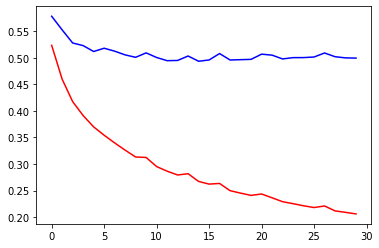

In [29]:
plt.plot(t, 'r')
plt.plot(v, 'b')

The final val loss is about 0.5, which is acceptable.
The curve of val loss is descending without a trend of ascending. This means the model is neither overfitting nor underfitting.

| BOW-count | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| lr = 0.0001  |   |   |   |
| BOW-tfidf  |   |   |   |
| BOCN-count  |   |   |   |
| BOCN-tfidf  |   |   |   |
| BOW+BOCN  |   |   |   |

#### Evaluation

Compute accuracy, precision, recall and F1-scores:

In [30]:
preds_te_count = predict_class(test_vec, w_count)
print('Accuracy:', accuracy_score(test_label,preds_te_count))
print('Precision:', precision_score(test_label,preds_te_count))
print('Recall:', recall_score(test_label,preds_te_count))
print('F1-Score:', f1_score(test_label,preds_te_count))

Accuracy: 0.8245614035087719
Precision: 0.8177339901477833
Recall: 0.8341708542713567
F1-Score: 0.8258706467661691


Finally, print the top-10 words for the negative and positive class respectively.

In [31]:
top_neg = w_count.argsort()[:10]
for i in top_neg:
    print(id_to_vocab[i])

bad
supposed
worst
waste
boring
attempt
ridiculous
script
write
stupid


In [32]:
top_pos = w_count.argsort()[::-1][:10]
for i in top_pos:
    print(id_to_vocab[i])

perfect
hilarious
excellent
enjoy
simple
great
true
memorable
movies
bit


The words 'bad', 'worst', 'waste', etc are used to express the negative feelings of a movie. The words 'perfect', 'enjoy', 'excellent', etc are used to express the positive feelings of a movie. As a result, this model is quite excellent.

If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

ANS:
No, the words used to express positive or negative feelings about a movie is different from those about a restaurant or laptop. For the restaurant reviews, words such as delicious, friendly, dirty, etc may be the features.

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

First, I create lists for learning rate, alpha, and epochs, each with four values. Then, use for loop to train the models and record the accuracy for each model if the final val loss is under 1. Last, pick up the model with the highest accuracy. The reason I use accuracy to choose the model is that both true positive and true negative are important in this model.Both of the positive reviews and negative reviews are important so the accuracy is what I need

If learning rate is small, the epochs needs to be large enough since the weight only changes a little during each epoch. If the learning rate is large, the epochs can be smaller. However, a learning rate that is too large results in unstable training and a learning rate that is too small results in failed training.

The larger the regularisation strength is, the bigger penalty term is. If the regularisation strength is near 0, the penalty term doesn't work, which means the model has a high possibility of overfitting.

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


### BOW-tfidf

In [33]:
if tune_params == 'Y':
    acc_history = []
    table_lr0 = PrettyTable(["lr = {}".format(lr[0]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr1 = PrettyTable(["lr = {}".format(lr[1]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr2 = PrettyTable(["lr = {}".format(lr[2]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr3 = PrettyTable(["lr = {}".format(lr[3]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    for i in range(len(lr)):
        for j in range(len(alpha)):
            for k in range(len(epochs)):
                w_tfidf, t_tfidf, v_tfidf = SGD(train_tfidf, train_label, X_dev=development_tfidf, Y_dev=development_label, lr=lr[i], alpha=alpha[j], epochs=epochs[k])
                preds_te_count = predict_class(test_tfidf, w_tfidf)
                if v_tfidf[len(v_tfidf)-1] < 1:
                    acc_history.append(accuracy_score(test_label,preds_te_count))
                else:
                    acc_history.append(0)
        if i == 0:
            table_lr0.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr0.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr0.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr0.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 1:
            table_lr1.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr1.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr1.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr1.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 2:
            table_lr2.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr2.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr2.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr2.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 3:
            table_lr3.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr3.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr3.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr3.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
    result = max(acc_history)
    print('max accuracy:', result)
    index_of_result = acc_history.index(result)
    lr_index = (index_of_result)//16
    alpha_index = (index_of_result%16)//4
    epochs_index = (index_of_result%4)
    print('lr: ', lr[lr_index])
    print('alpha: ', alpha[alpha_index])
    print('epochs: ', epochs[epochs_index])
    print(table_lr0)
    print(table_lr1)
    print(table_lr2)
    print(table_lr3)

max accuracy: 0.8421052631578947
lr:  0.001
alpha:  1e-06
epochs:  30
+--------------+--------------------+--------------------+--------------------+--------------------+
|  lr = 1e-06  |   alpha = 1e-06    |   alpha = 1e-05    |   alpha = 0.0001   |   alpha = 0.001    |
+--------------+--------------------+--------------------+--------------------+--------------------+
| epochs = 30  | 0.6090225563909775 | 0.6090225563909775 | 0.6090225563909775 | 0.6090225563909775 |
| epochs = 75  | 0.6265664160401002 | 0.6265664160401002 | 0.6265664160401002 | 0.6265664160401002 |
| epochs = 120 | 0.6491228070175439 | 0.6491228070175439 | 0.6491228070175439 | 0.6491228070175439 |
| epochs = 165 | 0.6691729323308271 | 0.6691729323308271 | 0.6691729323308271 | 0.6691729323308271 |
+--------------+--------------------+--------------------+--------------------+--------------------+
+--------------+--------------------+--------------------+--------------------+--------------------+
|  lr = 1e-05  |   al

In [34]:
if tune_params == 'Y':
    w_tfidf, t_tfidf, v_tfidf = SGD(train_tfidf, train_label, X_dev=development_tfidf, Y_dev=development_label, 
                                lr=lr[lr_index], alpha=alpha[alpha_index], epochs=epochs[epochs_index], print_progress=True)
else:
    w_tfidf, t_tfidf, v_tfidf = SGD(train_tfidf, train_label, X_dev=development_tfidf, Y_dev=development_label, print_progress=True)

train loss:  [0.5821423604447067, 0.5191824525351423, 0.4771485270391641, 0.4455105209681702, 0.4206253516438873, 0.4004119687788791, 0.3834264214319399, 0.36873649830226524, 0.3559369071707424, 0.34458945221997633, 0.33442878925625347, 0.3251911145364116, 0.31680218695582163, 0.30913201678853824, 0.30205401863364145, 0.29561387714164516, 0.289374353545951, 0.28366865282050013, 0.2783334226875282, 0.2731890999786553, 0.26847640662830324, 0.2642349730304086, 0.2598222304485384, 0.25554997408348923, 0.25167316304893955, 0.24800368139970355, 0.24449192831281358, 0.24118190275631513, 0.2378454268603819, 0.23487269208847114]
------------------------------------------------
val loss:  [0.6188721607708753, 0.5797247672149108, 0.5554238039052309, 0.5379952194868945, 0.5250780603283466, 0.5154174859931234, 0.5076522389648609, 0.5010153830232392, 0.4955418407020135, 0.4915979604982202, 0.4878159080322553, 0.4843017757290691, 0.48141259526981806, 0.47906874017566115, 0.47705445595394064, 0.475678

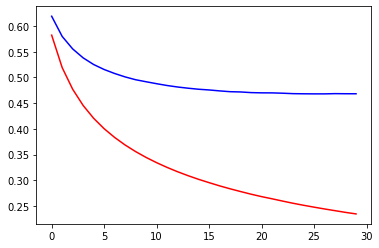

In [35]:
plt.plot(t_tfidf, 'r')
plt.plot(v_tfidf, 'b')

The final val loss is about 0.5, which is acceptable.
The curve of val loss is descending without a trend of ascending. This means the model is neither overfitting nor underfitting.

In [36]:
preds_te_count = predict_class(test_tfidf, w_tfidf)
print('Accuracy:', accuracy_score(test_label,preds_te_count))
print('Precision:', precision_score(test_label,preds_te_count))
print('Recall:', recall_score(test_label,preds_te_count))
print('F1-Score:', f1_score(test_label,preds_te_count))

Accuracy: 0.8421052631578947
Precision: 0.8333333333333334
Recall: 0.8542713567839196
F1-Score: 0.8436724565756824


In [37]:
top_neg = w_tfidf.argsort()[:10]
for i in top_neg:
    print(id_to_vocab[i])

bad
worst
supposed
boring
waste
ridiculous
awful
fails
script
filmmakers


In [38]:
top_pos = w_tfidf.argsort()[::-1][:10]
for i in top_pos:
    print(id_to_vocab[i])

perfect
hilarious
great
excellent
terrific
memorable
simple
perfectly
world
enjoyed


The words 'bad', 'worst', 'boring', etc are used to express the negative feelings of a movie. The words 'perfect', 'terrific', 'memorable', etc are used to express the positive feelings of a movie. As a result, this model is quite excellent.

### Now repeat the training and evaluation process for BOW-tfidf, BOCN-count, BOCN-tfidf, BOW+BOCN including hyperparameter tuning for each model...

### BOCN-count

In [39]:
vocab_bocn, df_bocn, tf_bocn = get_vocab(X_raw=train_content,min_df=55, keep_topN=75, char_ngrams=True)

In [40]:
vocab_bocn_to_id = {}
id_to_vocab_bocn = {}
for word in vocab_bocn:
    string = " ".join(word)
    vocab_bocn_to_id[string] = vocab_bocn.index(word)
    id_to_vocab_bocn[vocab_bocn.index(word)] = string

In [41]:
train_vec_bocn = vectorise(X_ngram=processed_train_content, vocab=vocab_bocn)
development_vec_bocn = vectorise(X_ngram=processed_dev_content, vocab=vocab_bocn)
test_vec_bocn = vectorise(X_ngram=processed_test_content, vocab=vocab_bocn)

In [42]:
import math
idf_bocn = {}
for key, value in df_bocn.items():
    idf_bocn[key] = math.log(len(train_content)/value,10)

In [43]:
idf_bocn_list = list(idf_bocn.values())

In [44]:
train_tfidf_bocn = compute_tfidf(idf_list=idf_bocn_list, vec=train_vec_bocn)
development_tfidf_bocn = compute_tfidf(idf_list=idf_bocn_list, vec=development_vec_bocn)
test_tfidf_bocn = compute_tfidf(idf_list=idf_bocn_list, vec=test_vec_bocn)

In [45]:
if tune_params == 'Y':
    acc_history = []
    table_lr0 = PrettyTable(["lr = {}".format(lr[0]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr1 = PrettyTable(["lr = {}".format(lr[1]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr2 = PrettyTable(["lr = {}".format(lr[2]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr3 = PrettyTable(["lr = {}".format(lr[3]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    for i in range(len(lr)):
        for j in range(len(alpha)):
            for k in range(len(epochs)):
                w_count_bocn, t_bocn, v_bocn = SGD(train_vec_bocn, train_label, X_dev=development_vec_bocn, Y_dev=development_label, lr=lr[i], alpha=alpha[j], epochs=epochs[k])
                preds_te_count = predict_class(test_vec_bocn, w_count_bocn)
                if v_bocn[len(v_bocn)-1] < 1:
                    acc_history.append(accuracy_score(test_label,preds_te_count))
                else:
                    acc_history.append(0)
        if i == 0:
            table_lr0.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr0.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr0.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr0.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 1:
            table_lr1.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr1.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr1.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr1.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 2:
            table_lr2.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr2.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr2.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr2.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 3:
            table_lr3.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr3.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr3.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr3.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
    result = max(acc_history)
    print('max accuracy:', result)
    index_of_result = acc_history.index(result)
    lr_index = (index_of_result)//16
    alpha_index = (index_of_result%16)//4
    epochs_index = (index_of_result%4)
    print('lr: ', lr[lr_index])
    print('alpha: ', alpha[alpha_index])
    print('epochs: ', epochs[epochs_index])
    print(table_lr0)
    print(table_lr1)
    print(table_lr2)
    print(table_lr3)

<ipython-input-24-1c73d9e9e108>:11: RuntimeWarning: divide by zero encountered in log
  l_first = (np.dot(np.transpose(-Y), (np.log(y))) - np.dot(np.transpose(1-Y), (np.log(1-y))))/len(Y)


max accuracy: 0.7869674185463659
lr:  1e-05
alpha:  1e-06
epochs:  120
+--------------+--------------------+--------------------+--------------------+--------------------+
|  lr = 1e-06  |   alpha = 1e-06    |   alpha = 1e-05    |   alpha = 0.0001   |   alpha = 0.001    |
+--------------+--------------------+--------------------+--------------------+--------------------+
| epochs = 30  | 0.7042606516290727 | 0.7042606516290727 | 0.7042606516290727 | 0.7042606516290727 |
| epochs = 75  | 0.7268170426065163 | 0.7268170426065163 | 0.7268170426065163 | 0.7268170426065163 |
| epochs = 120 | 0.7343358395989975 | 0.7343358395989975 | 0.7343358395989975 | 0.7343358395989975 |
| epochs = 165 | 0.7418546365914787 | 0.7418546365914787 | 0.7418546365914787 | 0.7418546365914787 |
+--------------+--------------------+--------------------+--------------------+--------------------+
+--------------+--------------------+--------------------+--------------------+--------------------+
|  lr = 1e-05  |   a

In [46]:
if tune_params == 'Y':
    w_count_bocn, t_bocn, v_bocn = SGD(train_vec_bocn, train_label, X_dev=development_vec_bocn, Y_dev=development_label,
                                      lr=lr[lr_index], alpha=alpha[alpha_index], epochs=epochs[epochs_index], print_progress=True)
else:
    w_count_bocn, t_bocn, v_bocn = SGD(train_vec_bocn, train_label, X_dev=development_vec_bocn, Y_dev=development_label, print_progress=True)        

train loss:  [0.6586678865543996, 0.6409576538108084, 0.614961752041814, 0.6099612622626234, 0.6050659590053403, 0.5941109401285373, 0.5721538260755585, 0.6165177248681937, 0.566789992670101, 0.551701504992079, 0.5748317519206638, 0.5565582981160806, 0.5505612337997011, 0.5310324752930027, 0.53272522450547, 0.5204643130489307, 0.5195529458636964, 0.51419421594282, 0.5115296745251963, 0.5053134249491735, 0.5402928891318021, 0.49891279946082934, 0.49711488254886027, 0.502233472414653, 0.4900059660727521, 0.5120546353977561, 0.4915674117822513, 0.48343438281031853, 0.48589857812322446, 0.4792423396467732, 0.47528670720434685, 0.47420522320685415, 0.4820408484794968, 0.470250683620504, 0.4672661452776422, 0.46446897579310625, 0.4673847070834981, 0.4667535314683005, 0.467561051568702, 0.4649346457598132, 0.454931236776774, 0.5024440397583462, 0.4513051951032547, 0.4502441373159806, 0.48183475374283263, 0.4504327395814808, 0.44976175360269477, 0.44327001845302216, 0.442759881454071, 0.440321

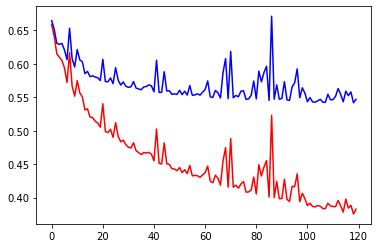

In [47]:
plt.plot(t_bocn, 'r')
plt.plot(v_bocn, 'b')

This is a unstable training, which means the learning rate may be too large for this model. However, the final val loss and accuracy are still acceptable.

In [48]:
preds_te_count_bocn = predict_class(test_vec_bocn, w_count_bocn)
print('Accuracy:', accuracy_score(test_label,preds_te_count_bocn))
print('Precision:', precision_score(test_label,preds_te_count_bocn))
print('Recall:', recall_score(test_label,preds_te_count_bocn))
print('F1-Score:', f1_score(test_label,preds_te_count_bocn))

Accuracy: 0.7869674185463659
Precision: 0.7821782178217822
Recall: 0.7939698492462312
F1-Score: 0.7880299251870324


In [49]:
top_neg = w_count_bocn.argsort()[:10]
for i in top_neg:
    print(id_to_vocab_bocn[i])

bad
rs
ad
te
ors
ba
p
st
gu
gi


In [50]:
top_pos = w_count_bocn.argsort()[::-1][:10]
for i in top_pos:
    print(id_to_vocab_bocn[i])

li
per
rf
erf
od
fu
gr
gre
is
la


Here we get 'bad' for the negative reviews. Also, 'per', 'gre', 'erf', seems like 'perfect' and 'great' in positive reviews. Thus, this model is also reasonable.

### BOCN-tfidf

In [51]:
if tune_params == 'Y':
    acc_history = []
    table_lr0 = PrettyTable(["lr = {}".format(lr[0]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr1 = PrettyTable(["lr = {}".format(lr[1]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr2 = PrettyTable(["lr = {}".format(lr[2]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr3 = PrettyTable(["lr = {}".format(lr[3]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    for i in range(len(lr)):
        for j in range(len(alpha)):
            for k in range(len(epochs)):
                w_tfidf_bocn, t_tfidf_bocn, v_tfidf_bocn = SGD(train_tfidf_bocn, train_label, X_dev=development_tfidf_bocn, Y_dev=development_label, lr=lr[i], alpha=alpha[j], epochs=epochs[k])
                preds_te_count = predict_class(test_tfidf_bocn, w_tfidf_bocn)
                if v_tfidf_bocn[len(v_tfidf_bocn)-1] < 1:
                    acc_history.append(accuracy_score(test_label,preds_te_count))
                else:
                    acc_history.append(0)
        if i == 0:
            table_lr0.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr0.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr0.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr0.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 1:
            table_lr1.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr1.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr1.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr1.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 2:
            table_lr2.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr2.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr2.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr2.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 3:
            table_lr3.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr3.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr3.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr3.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
    result = max(acc_history)
    print('max accuracy:', result)
    index_of_result = acc_history.index(result)
    lr_index = (index_of_result)//16
    alpha_index = (index_of_result%16)//4
    epochs_index = (index_of_result%4)
    print('lr: ', lr[lr_index])
    print('alpha: ', alpha[alpha_index])
    print('epochs: ', epochs[epochs_index])
    print(table_lr0)
    print(table_lr1)
    print(table_lr2)
    print(table_lr3)

max accuracy: 0.8345864661654135
lr:  0.0001
alpha:  1e-06
epochs:  165
+--------------+--------------------+--------------------+--------------------+--------------------+
|  lr = 1e-06  |   alpha = 1e-06    |   alpha = 1e-05    |   alpha = 0.0001   |   alpha = 0.001    |
+--------------+--------------------+--------------------+--------------------+--------------------+
| epochs = 30  | 0.5639097744360902 | 0.5639097744360902 | 0.5639097744360902 | 0.5639097744360902 |
| epochs = 75  | 0.5839598997493735 | 0.5839598997493735 | 0.5839598997493735 | 0.5839598997493735 |
| epochs = 120 | 0.6290726817042607 | 0.6290726817042607 | 0.6290726817042607 | 0.6290726817042607 |
| epochs = 165 | 0.6466165413533834 | 0.6466165413533834 | 0.6466165413533834 | 0.6466165413533834 |
+--------------+--------------------+--------------------+--------------------+--------------------+
+--------------+--------------------+--------------------+--------------------+--------------------+
|  lr = 1e-05  |   

In [52]:
if tune_params == 'Y':
    w_tfidf_bocn, t_tfidf_bocn, v_tfidf_bocn = SGD(train_tfidf_bocn, train_label, X_dev=development_tfidf_bocn,
                                                   Y_dev=development_label,lr=lr[lr_index], alpha=alpha[alpha_index],
                                                   epochs=epochs[epochs_index], print_progress=True)
else:
    w_tfidf_bocn, t_tfidf_bocn, v_tfidf_bocn = SGD(train_tfidf_bocn, train_label,
                                                   X_dev=development_tfidf_bocn, Y_dev=development_label,print_progress=True)

train loss:  [0.681458442528966, 0.6711049079825542, 0.6615120432983105, 0.6525627309449156, 0.644122907984897, 0.6361412955962436, 0.628572718914092, 0.6213843236872093, 0.6145407854238141, 0.6080267079756276, 0.6018109413717951, 0.5958745143890353, 0.5901966065070277, 0.5847585483407477, 0.5795432190294567, 0.5745344793852059, 0.5697189752673516, 0.565080162874092, 0.5606187557619792, 0.5563127654729154, 0.5521559545579795, 0.5481459773742027, 0.5442693642569337, 0.5405060459593192, 0.536866882725984, 0.5333422719183369, 0.529922478049714, 0.5266035268968914, 0.5233796612711548, 0.520242842405782, 0.5171968429622555, 0.5142292337685429, 0.511340007973965, 0.5085263546740816, 0.5057828769010678, 0.5031063165920482, 0.5004938093366652, 0.49794630533921563, 0.49545441537364154, 0.49302266495941144, 0.4906438404704505, 0.4883188390709106, 0.48604404691858927, 0.4838176166001264, 0.4816382148925806, 0.4795036303255345, 0.4774131552726171, 0.47536227280423987, 0.47335248372816224, 0.471382

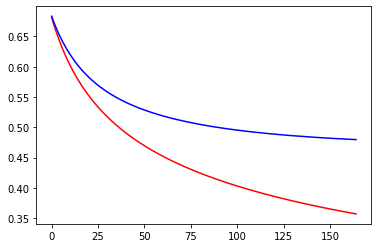

In [53]:
plt.plot(t_tfidf_bocn, 'r')
plt.plot(v_tfidf_bocn, 'b')

The final val loss is about 0.5, which is acceptable.
The curve of val loss is descending without a trend of ascending. This means the model is neither overfitting nor underfitting.

In [54]:
preds_te_tfidf_bocn = predict_class(test_tfidf_bocn, w_tfidf_bocn)
print('Accuracy:', accuracy_score(test_label,preds_te_tfidf_bocn))
print('Precision:', precision_score(test_label,preds_te_tfidf_bocn))
print('Recall:', recall_score(test_label,preds_te_tfidf_bocn))
print('F1-Score:', f1_score(test_label,preds_te_tfidf_bocn))

Accuracy: 0.8345864661654135
Precision: 0.8181818181818182
Recall: 0.8592964824120602
F1-Score: 0.838235294117647


In [55]:
top_neg = w_tfidf_bocn.argsort()[:10]
for i in top_neg:
    print(id_to_vocab_bocn[i])

bad
bor
ipt
ulo
wfu
ors
awf
mpt
wf
upi


In [56]:
top_pos = w_tfidf_bocn.argsort()[::-1][:10]
for i in top_pos:
    print(id_to_vocab_bocn[i])

rfe
ila
erf
gre
rf
rue
rld
osc
rfu
fic


Here we get 'bad', 'awf', 'wuf', 'wf' for 'bad' and 'awful' in negative reviews. Similarly, we get 'rfe', 'erf', and 'rf' for 'perfect' in positive reviews. Thus, this model is also reasonable.

### BOW+BOCN

In [57]:
train_bow_bocn_tfidf = np.concatenate((train_tfidf,train_tfidf_bocn), axis=1)
development_bow_bocn_tfidf = np.concatenate((development_tfidf,development_tfidf_bocn), axis=1)
test_bow_bocn_tfidf = np.concatenate((test_tfidf,test_tfidf_bocn), axis=1)

In [58]:
if tune_params == 'Y':
    acc_history = []
    table_lr0 = PrettyTable(["lr = {}".format(lr[0]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr1 = PrettyTable(["lr = {}".format(lr[1]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr2 = PrettyTable(["lr = {}".format(lr[2]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    table_lr3 = PrettyTable(["lr = {}".format(lr[3]), "alpha = {}".format(alpha[0]), "alpha = {}".format(alpha[1])
                , "alpha = {}".format(alpha[2]), "alpha = {}".format(alpha[3])])
    for i in range(len(lr)):
        for j in range(len(alpha)):
            for k in range(len(epochs)):
                w_bow_bocn_tfidf, t_bow_bocn_tfidf, v_bow_bocn_tfidf = SGD(X_tr=train_bow_bocn_tfidf, Y_tr=train_label, X_dev=development_bow_bocn_tfidf, Y_dev=development_label, lr=lr[i], alpha=alpha[j], epochs=epochs[k])
                preds_te_bow_bocn_tfidf = predict_class(test_bow_bocn_tfidf, w_bow_bocn_tfidf)
                if v_bow_bocn_tfidf[len(v_bow_bocn_tfidf)-1] < 1:
                    acc_history.append(accuracy_score(test_label,preds_te_bow_bocn_tfidf))
                else:
                    acc_history.append(0)
        if i == 0:
            table_lr0.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr0.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr0.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr0.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 1:
            table_lr1.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr1.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr1.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr1.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 2:
            table_lr2.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr2.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr2.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr2.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
        if i == 3:
            table_lr3.add_row(["epochs = {}".format(epochs[0]), acc_history[i*16+0], acc_history[i*16+4], acc_history[i*16+8], acc_history[i*16+12]])
            table_lr3.add_row(["epochs = {}".format(epochs[1]), acc_history[i*16+1], acc_history[i*16+5], acc_history[i*16+9], acc_history[i*16+13]])
            table_lr3.add_row(["epochs = {}".format(epochs[2]), acc_history[i*16+2], acc_history[i*16+6], acc_history[i*16+10], acc_history[i*16+14]])
            table_lr3.add_row(["epochs = {}".format(epochs[3]), acc_history[i*16+3], acc_history[i*16+7], acc_history[i*16+11], acc_history[i*16+15]])
    result = max(acc_history)
    print('max accuracy:', result)
    index_of_result = acc_history.index(result)
    lr_index = (index_of_result)//16
    alpha_index = (index_of_result%16)//4
    epochs_index = (index_of_result%4)
    print('lr: ', lr[lr_index])
    print('alpha: ', alpha[alpha_index])
    print('epochs: ', epochs[epochs_index])
    print(table_lr0)
    print(table_lr1)
    print(table_lr2)
    print(table_lr3)

max accuracy: 0.8571428571428571
lr:  0.001
alpha:  1e-06
epochs:  30
+--------------+--------------------+--------------------+--------------------+--------------------+
|  lr = 1e-06  |   alpha = 1e-06    |   alpha = 1e-05    |   alpha = 0.0001   |   alpha = 0.001    |
+--------------+--------------------+--------------------+--------------------+--------------------+
| epochs = 30  | 0.6165413533834586 | 0.6165413533834586 | 0.6165413533834586 | 0.6165413533834586 |
| epochs = 75  | 0.6466165413533834 | 0.6466165413533834 | 0.6466165413533834 | 0.6466165413533834 |
| epochs = 120 | 0.6917293233082706 | 0.6917293233082706 | 0.6917293233082706 | 0.6917293233082706 |
| epochs = 165 | 0.7192982456140351 | 0.7192982456140351 | 0.7192982456140351 | 0.7192982456140351 |
+--------------+--------------------+--------------------+--------------------+--------------------+
+--------------+--------------------+--------------------+--------------------+--------------------+
|  lr = 1e-05  |   al

In [59]:
if tune_params == 'Y':
    w_bow_bocn_tfidf, t_bow_bocn_tfidf, v_bow_bocn_tfidf = SGD(train_bow_bocn_tfidf, train_label, X_dev=development_bow_bocn_tfidf,
                                                               Y_dev=development_label, lr=lr[lr_index], alpha=alpha[alpha_index],
                                                               epochs=epochs[epochs_index], print_progress=True)
else:
    w_bow_bocn_tfidf, t_bow_bocn_tfidf, v_bow_bocn_tfidf = SGD(train_bow_bocn_tfidf, train_label, X_dev=development_bow_bocn_tfidf,
                                                               Y_dev=development_label, print_progress=True)

train loss:  [0.5326226599730167, 0.4608078445091674, 0.4171088783073348, 0.38533661616981485, 0.3612415661834907, 0.34203780290868385, 0.3261362514754283, 0.3125426275771912, 0.30092211849012984, 0.29043550946735486, 0.281296956930362, 0.2728883377198892, 0.2653410593908214, 0.258502002935498, 0.25214064668513586, 0.24680485572422978, 0.2408931465385257, 0.23602232448544883, 0.23117783271573916, 0.22651852156520985, 0.22259348905669524, 0.2193859255885909, 0.2149572798015082, 0.21098378943928875, 0.20755885359677753, 0.20434022663679863, 0.20126684908663325, 0.198481190758188, 0.19540744074028224, 0.1931055893962769]
------------------------------------------------
val loss:  [0.5802836441951238, 0.5364640899039577, 0.5133538564140353, 0.4975822807445059, 0.48759905759390165, 0.4804719340733244, 0.47529928541722805, 0.4710506616489357, 0.46816921363955033, 0.4673238564444099, 0.4660015386253393, 0.4644367226877555, 0.46354491325260716, 0.46301853090826534, 0.463049482937284, 0.4648087

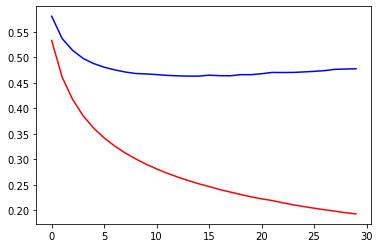

In [60]:
plt.plot(t_bow_bocn_tfidf, 'r')
plt.plot(v_bow_bocn_tfidf, 'b')

The final val loss is about 0.5, which is acceptable.
The curve of val loss is descending without a trend of ascending. This means the model is neither overfitting nor underfitting.

In [61]:
preds_te_bow_bocn_tfidf = predict_class(test_bow_bocn_tfidf, w_bow_bocn_tfidf)
print('Accuracy:', accuracy_score(test_label,preds_te_bow_bocn_tfidf))
print('Precision:', precision_score(test_label,preds_te_bow_bocn_tfidf))
print('Recall:', recall_score(test_label,preds_te_bow_bocn_tfidf))
print('F1-Score:', f1_score(test_label,preds_te_bow_bocn_tfidf))

Accuracy: 0.8571428571428571
Precision: 0.855
Recall: 0.8592964824120602
F1-Score: 0.8571428571428571


In [62]:
id_to_vocab_bow_bocn = {**id_to_vocab_bocn, **id_to_vocab}

In [63]:
top_neg = w_bow_bocn_tfidf.argsort()[:10]
for i in top_neg:
    print(id_to_vocab_bow_bocn[i])

bad
cam
waste
worst
boring
supposed
fails
flat
worse
ridiculous


In [64]:
top_pos = w_bow_bocn_tfidf.argsort()[::-1][:10]
for i in top_pos:
    print(id_to_vocab_bow_bocn[i])

hilarious
great
excellent
simple
terrific
perfect
fiction
nfe
memorable
perfectly


Here we get 'fails', 'worse', etc. for negative reviews and 'great', 'terrific', etc. for positive reviews. Thus, this model performs well.



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |0.8177339901477833|0.8341708542713567|0.8258706467661691|
| BOW-tfidf  |0.8333333333333334|0.8542713567839196|0.8436724565756824|
| BOCN-count  |0.7821782178217822|0.7939698492462312|0.7880299251870324|
| BOCN-tfidf  |0.8181818181818182|0.8592964824120602|0.838235294117647|
| BOW+BOCN  |0.855|0.8592964824120602|0.8571428571428571|

Please discuss why your best performing model is better than the rest.

ANS:
My best performing model is BOW+BOCN. This is because this model has more features than the other four models. Also, this model does not include many noises as features. Thus, this model performs best.